In [1]:
import pandas as pd
import numpy as np 
import seaborn as sns 
import matplotlib.pyplot as plt
import plotly.express as px

from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder, StandardScaler
from sklearn.impute import SimpleImputer, KNNImputer
from sklearn.base import BaseEstimator, TransformerMixin 
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split, cross_val_score, RandomizedSearchCV, GridSearchCV, KFold
from sklearn.linear_model import LogisticRegression, LinearRegression, SGDRegressor
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier, BaggingClassifier, RandomForestRegressor
from sklearn.neighbors import KNeighborsClassifier, KNeighborsRegressor
from sklearn.svm import LinearSVC, SVR
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor
from sklearn.metrics import ConfusionMatrixDisplay, f1_score, make_scorer, confusion_matrix, mean_squared_error, mean_absolute_error

from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.tools.tools import add_constant 

from xgboost import XGBClassifier, XGBRegressor
from catboost import CatBoostClassifier

from scipy.stats import randint, uniform

import os
import kagglehub

c:\Users\erika\anaconda3\envs\dsa\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


### 1.basic Cleaning and Creating Train/Test Split
1.1 Reading in the data and inspection

In [2]:
# Download latest version
path = kagglehub.dataset_download("xiaomengsun/car-insurance-claim-data")

print("Path to dataset files:", path)
print("Contents:", os.listdir(path))

file_path = os.path.join(path, "car_insurance_claim.csv" )

# Load itt as a DataFrame
raw_data = pd.read_csv(file_path)

#Show the first few rows
pd.set_option('display.max_columns', None)
raw_data.head()

Path to dataset files: C:\Users\erika\.cache\kagglehub\datasets\xiaomengsun\car-insurance-claim-data\versions\1
Contents: ['car_insurance_claim.csv']


,ID,KIDSDRIV,BIRTH,AGE,HOMEKIDS,YOJ,INCOME,PARENT1,HOME_VAL,MSTATUS,GENDER,EDUCATION,OCCUPATION,TRAVTIME,CAR_USE,BLUEBOOK,TIF,CAR_TYPE,RED_CAR,OLDCLAIM,CLM_FREQ,REVOKED,MVR_PTS,CLM_AMT,CAR_AGE,CLAIM_FLAG,URBANICITY
0,63581743,0,16MAR39,60.0,0,11.0,"$67,349",No,$0,z_No,M,PhD,Professional,14,Private,"$14,230",11,Minivan,yes,"$4,461",2,No,3,$0,18.0,0,Highly Urban/ Urban
1,132761049,0,21JAN56,43.0,0,11.0,"$91,449",No,"$257,252",z_No,M,z_High School,z_Blue Collar,22,Commercial,"$14,940",1,Minivan,yes,$0,0,No,0,$0,1.0,0,Highly Urban/ Urban
2,921317019,0,18NOV51,48.0,0,11.0,"$52,881",No,$0,z_No,M,Bachelors,Manager,26,Private,"$21,970",1,Van,yes,$0,0,No,2,$0,10.0,0,Highly Urban/ Urban
3,727598473,0,05MAR64,35.0,1,10.0,"$16,039",No,"$124,191",Yes,z_F,z_High School,Clerical,5,Private,"$4,010",4,z_SUV,no,"$38,690",2,No,3,$0,10.0,0,Highly Urban/ Urban
4,450221861,0,05JUN48,51.0,0,14.0,NaN,No,"$306,251",Yes,M,<High School,z_Blue Collar,32,Private,"$15,440",7,Minivan,yes,$0,0,No,0,$0,6.0,0,Highly Urban/ Urban


### Variables and Descripctions
INDEX - Unique identifier  
TARGET_FLAG - Claim has been made  
TARGET_AMT - Claim value  
AGE - Age of driver  
BLUEBOOK - Value of vehicle  
CAR_AGE - Car age in years  
CAR_TYPE Type of vehicle  
CLM_FRQ - Number of claims in past 5 years  
EDUCATION - Highest level of education completed by policyholder  
HOMEKIDS - NUmber of child at policyholder's address  
HOME_VAL -  vALUE OF POLICYHOLDER'S HOME  
INCOME - Income of policy holder  
JOB - Type of job held by policyholder  
KIDSDRIV - Number of children with access to policyholder's vehicle  
MSTATUS - marital status  
OLDCLAIM - Total value of claims in part 5 years  
PARENT1 - Single parent  
RED_CAR - Vehicle is red in colour  
REVOKED - Licence has been revoked in past 7 years  
SEX - Gender  
TIF -  Policy tenure  
TRAVTIME - Commute distance  
URVANCITY - Address area type (urban/rural)  
TOJ - Years polyholder's job has been held for  

We don't want to fundamentely change any data as we still not split our data into a test/train set. So we want to avoid any data leakage

#### 1.2 Basic Data Cleaning 


In [3]:
# Create new copy of data
data_df = raw_data.copy()

In [4]:
# define updated column names
col_names = {
       'KIDSDRIV': 'num_young_drivers',
    'BIRTH': 'date_of_birth',
    'AGE': 'age',
    'HOMEKIDS': 'num_of_children',
    'YOJ': 'years_job_held_for',
    'INCOME': 'income',
    'PARENT1': 'single_parent',
    'HOME_VAL': 'value_of_home',
    'MSTATUS': 'married',
    'GENDER': 'gender',
    'EDUCATION': 'highest_education',
    'OCCUPATION': 'occupation',
    'TRAVTIME': 'commute_dist',
    'CAR_USE': 'type_of_use',
    'BLUEBOOK': 'vehicle_value',
    'TIF': 'policy_tenure',
    'CAR_TYPE': 'vehicle_type',
    'RED_CAR': 'red_vehicle',
    'OLDCLAIM': '5_year_total_claims_value',
    'CLM_FREQ': '5_year_num_of_claims',
    'REVOKED': 'licence_revoked',
    'MVR_PTS': 'license_points',
    'CLM_AMT': 'new_claim_value',
    'CAR_AGE': 'vehicle_age',
    'CLAIM_FLAG': 'is_claim',
    'URBANICITY': 'address_type'

}

# Update col names
data_df.rename(columns = col_names, inplace = True)


In [5]:
# Summary the data
data_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10302 entries, 0 to 10301
Data columns (total 27 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   ID                         10302 non-null  int64  
 1   num_young_drivers          10302 non-null  int64  
 2   date_of_birth              10302 non-null  object 
 3   age                        10295 non-null  float64
 4   num_of_children            10302 non-null  int64  
 5   years_job_held_for         9754 non-null   float64
 6   income                     9732 non-null   object 
 7   single_parent              10302 non-null  object 
 8   value_of_home              9727 non-null   object 
 9   married                    10302 non-null  object 
 10  gender                     10302 non-null  object 
 11  highest_education          10302 non-null  object 
 12  occupation                 9637 non-null   object 
 13  commute_dist               10302 non-null  int

In [6]:
# Check for duplicate records
data_df.duplicated().sum()

np.int64(1)

In [7]:
# Drop duplicates
data_df.drop_duplicates(inplace=True)

In [8]:
# Define currency cols
currency_cols = ['income', 'value_of_home', 'vehicle_value', '5_year_total_claims_value', 'new_claim_value']

# Create function to remove '$' and ','
def format_currency_cols(data, cols):
    for col in cols:
        data[col] = data[col].replace('[\\$,]', "", regex = True).astype('Int64')
    return data

data_df = format_currency_cols(data_df, currency_cols)


In [9]:
data_df.columns

Index(['ID', 'num_young_drivers', 'date_of_birth', 'age', 'num_of_children',
       'years_job_held_for', 'income', 'single_parent', 'value_of_home',
       'married', 'gender', 'highest_education', 'occupation', 'commute_dist',
       'type_of_use', 'vehicle_value', 'policy_tenure', 'vehicle_type',
       'red_vehicle', '5_year_total_claims_value', '5_year_num_of_claims',
       'licence_revoked', 'license_points', 'new_claim_value', 'vehicle_age',
       'is_claim', 'address_type'],
      dtype='object')

In [10]:
data_df.head()

,ID,num_young_drivers,date_of_birth,age,num_of_children,years_job_held_for,income,single_parent,value_of_home,married,gender,highest_education,occupation,commute_dist,type_of_use,vehicle_value,policy_tenure,vehicle_type,red_vehicle,5_year_total_claims_value,5_year_num_of_claims,licence_revoked,license_points,new_claim_value,vehicle_age,is_claim,address_type
0,63581743,0,16MAR39,60.0,0,11.0,67349,No,0,z_No,M,PhD,Professional,14,Private,14230,11,Minivan,yes,4461,2,No,3,0,18.0,0,Highly Urban/ Urban
1,132761049,0,21JAN56,43.0,0,11.0,91449,No,257252,z_No,M,z_High School,z_Blue Collar,22,Commercial,14940,1,Minivan,yes,0,0,No,0,0,1.0,0,Highly Urban/ Urban
2,921317019,0,18NOV51,48.0,0,11.0,52881,No,0,z_No,M,Bachelors,Manager,26,Private,21970,1,Van,yes,0,0,No,2,0,10.0,0,Highly Urban/ Urban
3,727598473,0,05MAR64,35.0,1,10.0,16039,No,124191,Yes,z_F,z_High School,Clerical,5,Private,4010,4,z_SUV,no,38690,2,No,3,0,10.0,0,Highly Urban/ Urban
4,450221861,0,05JUN48,51.0,0,14.0,<NA>,No,306251,Yes,M,<High School,z_Blue Collar,32,Private,15440,7,Minivan,yes,0,0,No,0,0,6.0,0,Highly Urban/ Urban


In [11]:
# Define cols that have prefix
z_prefix_cols = ['married', 'gender', 'highest_education', 'occupation', 'vehicle_type', 'address_type']

# Create a function to remove 'z_' prefix
def remove_prefix(data, cols):
    for col in cols:
        data[col] = data[col].replace('[z_]', '', regex = True)
    return data

data_df = remove_prefix(data_df, z_prefix_cols)




In [12]:
data_df.head()

,ID,num_young_drivers,date_of_birth,age,num_of_children,years_job_held_for,income,single_parent,value_of_home,married,gender,highest_education,occupation,commute_dist,type_of_use,vehicle_value,policy_tenure,vehicle_type,red_vehicle,5_year_total_claims_value,5_year_num_of_claims,licence_revoked,license_points,new_claim_value,vehicle_age,is_claim,address_type
0,63581743,0,16MAR39,60.0,0,11.0,67349,No,0,No,M,PhD,Professional,14,Private,14230,11,Minivan,yes,4461,2,No,3,0,18.0,0,Highly Urban/ Urban
1,132761049,0,21JAN56,43.0,0,11.0,91449,No,257252,No,M,High School,Blue Collar,22,Commercial,14940,1,Minivan,yes,0,0,No,0,0,1.0,0,Highly Urban/ Urban
2,921317019,0,18NOV51,48.0,0,11.0,52881,No,0,No,M,Bachelors,Manager,26,Private,21970,1,Van,yes,0,0,No,2,0,10.0,0,Highly Urban/ Urban
3,727598473,0,05MAR64,35.0,1,10.0,16039,No,124191,Yes,F,High School,Clerical,5,Private,4010,4,SUV,no,38690,2,No,3,0,10.0,0,Highly Urban/ Urban
4,450221861,0,05JUN48,51.0,0,14.0,<NA>,No,306251,Yes,M,<High School,Blue Collar,32,Private,15440,7,Minivan,yes,0,0,No,0,0,6.0,0,Highly Urban/ Urban


In [13]:
# Drop features we don't need
data_df.drop(['ID', 'date_of_birth'], axis = 1, inplace = True)

In [14]:
data_df.head()

,num_young_drivers,age,num_of_children,years_job_held_for,income,single_parent,value_of_home,married,gender,highest_education,occupation,commute_dist,type_of_use,vehicle_value,policy_tenure,vehicle_type,red_vehicle,5_year_total_claims_value,5_year_num_of_claims,licence_revoked,license_points,new_claim_value,vehicle_age,is_claim,address_type
0,0,60.0,0,11.0,67349,No,0,No,M,PhD,Professional,14,Private,14230,11,Minivan,yes,4461,2,No,3,0,18.0,0,Highly Urban/ Urban
1,0,43.0,0,11.0,91449,No,257252,No,M,High School,Blue Collar,22,Commercial,14940,1,Minivan,yes,0,0,No,0,0,1.0,0,Highly Urban/ Urban
2,0,48.0,0,11.0,52881,No,0,No,M,Bachelors,Manager,26,Private,21970,1,Van,yes,0,0,No,2,0,10.0,0,Highly Urban/ Urban
3,0,35.0,1,10.0,16039,No,124191,Yes,F,High School,Clerical,5,Private,4010,4,SUV,no,38690,2,No,3,0,10.0,0,Highly Urban/ Urban
4,0,51.0,0,14.0,<NA>,No,306251,Yes,M,<High School,Blue Collar,32,Private,15440,7,Minivan,yes,0,0,No,0,0,6.0,0,Highly Urban/ Urban


when creating our sets, we want to make sure there's no bias in the negative or positive classes. So that the sets are actually reprsentative of the customer data. To be clear, when I say the positive and negative classes I'm referring to the Target variable which in this project for the classification is the "is_claim" feature. The positive class is that the customer has made a claim and the negative class that they haven't made a claim. Since we have a feature that describes a claim value of customers that have claimed we can use this to do something called stratified sampling. This will avoid bias in the test set.  
We can create bins based on non-zero values for the claim value as thsi implies indirectly that the 'is_claim' feature is true, but we can double check this to make sure our assumptions is correct.

1.3 Create Train/Test Split

In [15]:
# Check there are no non-zero values for 'new_claim_value' where 'is_claim' = 1
mask = (data_df['new_claim_value'] > 0 ) & (data_df['is_claim'] ==0)
data_df[mask]

,num_young_drivers,age,num_of_children,years_job_held_for,income,single_parent,value_of_home,married,gender,highest_education,occupation,commute_dist,type_of_use,vehicle_value,policy_tenure,vehicle_type,red_vehicle,5_year_total_claims_value,5_year_num_of_claims,licence_revoked,license_points,new_claim_value,vehicle_age,is_claim,address_type


In [16]:
# Create histoplot for new Claim values

fig = px.histogram(data_df, x="new_claim_value", nbins = 10)
fig.show()


We can see that this shows a heavy  right skew. So when creating our strata bins it might be wise to create nonlinearly spaced bins to better capture the moer extreme values with few instances.

In [17]:
# Define bins
bins = list(range(0, 50001, 5000 )) + [np.inf]

# Define bin labels
labels = np.arange(1,12)

# Apply bins using cut
data_df['claim_value_cat'] = pd.cut(data_df['new_claim_value'], bins = bins, labels = labels, include_lowest= True)

In [20]:
bins

[0, 5000, 10000, 15000, 20000, 25000, 30000, 35000, 40000, 45000, 50000, inf]

<Axes: ylabel='claim_value_cat'>

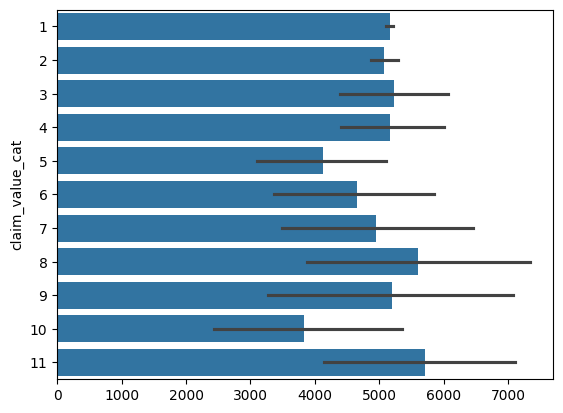

In [22]:
sns.barplot(data_df['claim_value_cat'])

In [19]:
data_df.head()

,num_young_drivers,age,num_of_children,years_job_held_for,income,single_parent,value_of_home,married,gender,highest_education,occupation,commute_dist,type_of_use,vehicle_value,policy_tenure,vehicle_type,red_vehicle,5_year_total_claims_value,5_year_num_of_claims,licence_revoked,license_points,new_claim_value,vehicle_age,is_claim,address_type,claim_value_cat
0,0,60.0,0,11.0,67349,No,0,No,M,PhD,Professional,14,Private,14230,11,Minivan,yes,4461,2,No,3,0,18.0,0,Highly Urban/ Urban,1
1,0,43.0,0,11.0,91449,No,257252,No,M,High School,Blue Collar,22,Commercial,14940,1,Minivan,yes,0,0,No,0,0,1.0,0,Highly Urban/ Urban,1
2,0,48.0,0,11.0,52881,No,0,No,M,Bachelors,Manager,26,Private,21970,1,Van,yes,0,0,No,2,0,10.0,0,Highly Urban/ Urban,1
3,0,35.0,1,10.0,16039,No,124191,Yes,F,High School,Clerical,5,Private,4010,4,SUV,no,38690,2,No,3,0,10.0,0,Highly Urban/ Urban,1
4,0,51.0,0,14.0,<NA>,No,306251,Yes,M,<High School,Blue Collar,32,Private,15440,7,Minivan,yes,0,0,No,0,0,6.0,0,Highly Urban/ Urban,1


In [24]:
# Show distributions with barplot
df = data_df['claim_value_cat'].value_counts().sort_values().reset_index()
df.columns = ['claim_value_cat', 'count']


fig = px.bar(df, x='claim_value_cat', y = 'count')
fig.show()